#

# 1. Implementing your own Shazam

In [1]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

### Utility functions

In [2]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    

### Settings

In [3]:

N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!
#data_folder = Path("data/mp3s-32k/")
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
print(mp3_tracks)
tracks = data_folder.glob("*/*/*.wav")



<generator object Path.glob at 0x7fcee0b80dd0>


### Preprocessing

In [4]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with clang version 11.1.0
  configuration: --prefix=/Users/leonardoplini/opt/anaconda3/envs/fds --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1627813741069/_build_env/bin/pkg-config
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
  libpostproc    55.  7.100 / 55.  7.100
[mp3 @ 0x7fc68380be00] Estimating duration from

### Audio signals

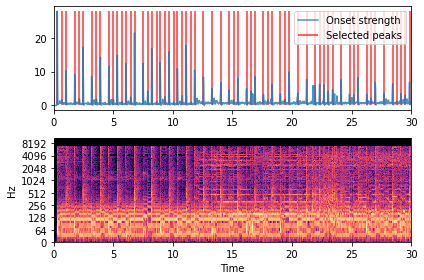

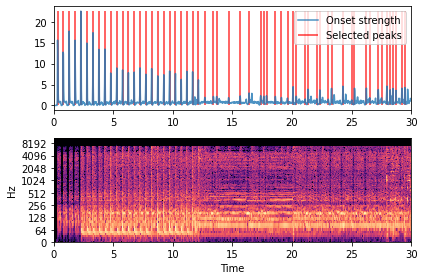

In [5]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)
        

### Minhash

In [ ]:
#prova


# 3. ALGORITHMIC QUESTION

You are given a list of integers, A, and another integer s. Write an algorithm that outputs all the pairs in A that equal x.

For example, if

A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] and s = 4
the algorithm should output: (7, -3), (-2, 6), (2, 2), (3, 1).

The running time of the algotith is proportional to $ n^2 $ since <br><br> $ =\sum_{i=1}^n (n-i-1) $ <br> <br> $ =\sum_{i=1}^{n} n - \sum_{i=1}^{n} i -\sum_{i=1}^{n} i $ <br><br> = $n^2 - \frac{n(n+1)}{2}-n $ <br><br> $= \frac{n^2}{2}-\frac{3n}{2} $ <br><br> $ \propto n^2 $

In [7]:
def algoritmo(A,s):
    result=[]
    for i in range(len(A)):
        j=i+1
        while j<len(A):
            if A[i]+A[j]==s:
                result.append((A[i],A[j]))
            j+=1
    print(result)

In [8]:
algoritmo([7,-2,8,2,6,4,-7,2,1,3,-3],4)

[(7, -3), (-2, 6), (2, 2), (1, 3)]
